In [1]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['svg.fonttype'] = 'none'

arr = np.asarray
import scanpy as sc
sc.settings.set_figure_params(dpi=80, color_map='coolwarm', frameon=True)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({"axes.grid.axis" : 'both'})
plt.rcParams.update({"axes.grid" : True})

In [2]:
import sys
import glob
sys.path.append("./code/")
from hic_zscore_functions import *
import initialize
# reload(initialize)
from initialize import *
from aux_functions import *

treg_250kb = cooler.Cooler('./Treg_all.mcool::/resolutions/250000')
treg_50kb = cooler.Cooler('./Treg_all.mcool::/resolutions/50000')
tcon_250kb = cooler.Cooler('./Tconv_all.mcool::/resolutions/250000')
tcon_50kb = cooler.Cooler('./Tconv_all.mcool::/resolutions/50000')

(chromsizes, parsed_chroms, region_to_inds, 
    all_region_to_ind, inds_to_region, all_ind_to_region, 
    chrom_to_start, chrom_to_end) = initialize_helper_vars(treg_250kb)

import pickle
gene_to_ind = pickle.load(open('gene_to_ind.p', 'rb'))

In [3]:
%load_ext autoreload
%autoreload
import scanpy as sc

sc.settings.set_figure_params(dpi=80, color_map='coolwarm', frameon=True)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({"axes.grid.axis" : 'both'})
plt.rcParams.update({"axes.grid" : True})

plt.rcParams.update({
    'axes.labelsize': 14,       # x and y labels' font size
    'xtick.labelsize': 8,      # x tick labels' font size
    'ytick.labelsize': 8,      # y tick labels' font size
    'axes.titlesize': 14,        # Axes title font size
    'patch.linewidth' : .35,
    'lines.linewidth' : .5,
    'legend.fontsize': 6,      # Legend font size
})
plt.rcParams['pdf.fonttype'] = 42

plt.rcParams.update({
    'axes.labelsize': 8,       # x and y labels' font size
    'xtick.labelsize': 6,      # x tick labels' font size
    'ytick.labelsize': 6,      # y tick labels' font size
    'axes.titlesize': 10,        # Axes title font size
    'patch.linewidth' : .35,
    'lines.linewidth' : .5,
    'xtick.major.pad' : 2,
    'ytick.major.pad' : 2,

})
plt.rcParams['axes.linewidth'] = .25
plt.rcParams['xtick.major.width'] = .25
plt.rcParams['ytick.major.width'] = .25
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['grid.linewidth'] = .25

plt.rcParams['axes.facecolor'] = 'none' # Or any suitable colour...
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'none'

plt.rcParams['axes.facecolor'] = 'none' # Or any suitable colour...
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'none'

In [4]:
CHROMS_TO_USE = ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9', 'X']

In [5]:
from matplotlib import transforms
def get_off_diag_mat_by_ind(cool, ind1, ind2, d, balance=False):
    chrom1, s1, _ = all_ind_to_region[ind1-d]
    chrom1, _, e1 = all_ind_to_region[ind1+d]
    
    chrom2, s2, _ = all_ind_to_region[ind2-d]
    chrom2, _, e2 = all_ind_to_region[ind2+d]
    if 'chr' in cool.chromnames[0]:
        m = cool.matrix(balance=balance).fetch(('chr' + chrom1, s1, e1), ('chr' + chrom2, s2, e2))
    else:
        m = cool.matrix(balance=balance).fetch((chrom1, s1, e1), (chrom2, s2, e2))
    return m


def get_off_diag_mat_by_places(cool, place1, place2, balance=False):
    chrom1, s1, e1 = place1
    chrom2, s2, e2 = place2
    if 'chr' in cool.chromnames[0]:
        m = cool.matrix(balance=balance).fetch(('chr' + chrom1, s1, e1), ('chr' + chrom2, s2, e2))
    else:
        m = cool.matrix(balance=balance).fetch((chrom1, s1, e1), (chrom2, s2, e2))
    return m

In [6]:
def get_tcon_mat(place1, place2, resolution=5000, balance=False, filesoi=None):
    cool = cooler.Cooler(f'./Tconv_all.mcool::/resolutions/{resolution}')
    try:
        mat = get_off_diag_mat_by_places(cool, place1, place2, balance=balance)
    except Exception as e:
        print(e)
    m = mat.astype(float)
    return m, place1, place2


def get_treg_mat(place1, place2, resolution=5000, balance=False, filesoi=None):
    cool = cooler.Cooler(f'./Treg_all.mcool::/resolutions/{resolution}')
    try:
        mat = get_off_diag_mat_by_places(cool, place1, place2, balance=balance)
    except Exception as e:
        print(e)
    m = mat.astype(float)
    return m, place1, place2

def get_non_treg_mat(place1, place2, filesoi, d=1, resolution=5000, **kwargs):
    ms = []
    files = []
    filesoi = cormat[(cormat.loc['./Treg_all.mcool'] > .8)].index
    for file in filesoi:
        try:
            cool = cooler.Cooler(f'{file}::/resolutions/{resolution}')
            mat = get_off_diag_mat_by_places(cool, place1, place2, balance=False)
        except Exception as e:
            print(e)
        ms.append(mat)
        files.append(file)
    ms = arr(ms)
    collapsemat = np.nansum(ms, axis=0).astype(float)
    m = collapsemat
    return m, place1, place2

### Find Metaloops

In [7]:
from skimage.feature import peak_local_max
from get_focal_contacts import *
C, O, L, R, U,D = set_filters()

def call_peak_with_poisson_and_peak_cutoff(image, sigma=1, pmin = 1e-300, logp_co = 10, more_than_min_co = 4):
    nanfilter_image = image.copy()
    nanfilter_image[np.isnan(nanfilter_image)] = 0
    filt_image = scipy.ndimage.gaussian_filter(nanfilter_image, sigma=1)
    n_C = C.sum()
    n_O = O.sum()
    
    frac_valid_C = 1-scipy.ndimage.correlate(np.isnan(image).astype(float), C)/n_C
    frac_valid_O = 1-scipy.ndimage.correlate(np.isnan(image).astype(float), O)/n_O
    
    counts_C = (scipy.ndimage.correlate(nanfilter_image, C)/frac_valid_C).astype(int)
    counts_O = (scipy.ndimage.correlate(nanfilter_image, O)/frac_valid_O).astype(int)
    
    pval_mat = scipy.stats.poisson(counts_O*n_C/n_O).sf(counts_C)+pmin
    logp_mat = -np.log10(pval_mat)
    is_sig = (logp_mat > logp_co)# & is_peak
#     med = np.mean(filt_image[filt_image > 0])
#     is_peak = is_peak*(filt_image > med*more_than_min_co)
    is_peak = peak_local_max(filt_image, indices=False) 
    row, col = np.where(is_sig)
    ind_mat = is_peak & is_sig
    no_edge_ind_mat = np.zeros_like(ind_mat)
    sl = slice(10, -10)
    no_edge_ind_mat[sl, sl] = ind_mat[sl, sl]
    peak_row, peak_col = np.where(no_edge_ind_mat)
    return filt_image, logp_mat, row, col, peak_row, peak_col

In [8]:
import math
from plotting_functions import *

def plot_inds(mat, i1, i2, d, ax=None, trans_func = lambda x: x, **kwargs):
    sl1 = slice(i1-d, i1+d+1)
    sl2 = slice(i2-d, i2+d+1)
    submat = trans_func(mat[sl1, sl2])
    if ax is None:
        fig, ax = plt.subplots()
    ax.matshow(submat, **kwargs)
    return submat.copy()


In [9]:
def make_comprehensive_plot(i1, i2, d=40, res=50_000, poiss_vmax=20, extend_by = 250_000):
    grange1 = (chrom, i1*res, i1*res+res)
    grange2 = (chrom, i2*res, i2*res+res)
    grange1, grange2 = map(lambda x: extend_l(x, extend_by), [grange1, grange2])
    collapsemat, filtmat, logp_mat, peak_row_starts, peak_col_starts = get_metaloops_at_grange(grange1, grange2, extend_by = 0)
    L, R = grange2[1:]
    T, B = grange1[1:]
    fig, axs = init_subplots(3, 1,)
    ax = axs[0]
    test = plot_mat(collapsemat, ax=ax, cmap='gist_heat_r', extent = [L, R, B, T], zorder=1);
    ax = axs[1]
    test = plot_mat(filtmat, ax=ax, cmap='gist_heat_r', extent = [L, R, B, T], zorder=1);
    ax = axs[2]
    test = plot_mat(logp_mat, ax=ax, cmap='bwr', extent = [L, R, B, T], zorder=1);
    
    ax = axs[0]
    y, x = peak_row_starts, peak_col_starts
    ax.scatter(x, y, facecolor='none', edgecolor='blue', linewidth=2, s=280, label='Metaloops')
    ax.legend()
    titles = ['Raw Data', 'Smoothed Data', 'Poisson P-value']
#     chrom1, chrom2 = all_ind_to_region_50kb[i1][0], all_ind_to_region_50kb[i2][0]
    for c, ax in enumerate(axs):
        ax.set_title(titles[c])
        ax.tick_params(axis='both', which='both', right=False, top=False, 
                       labelright=False, labeltop=False, bottom=True, labelbottom=True,
                      )  # Remove tick labels from top and right axes
        ax.ticklabel_format(axis='both', style='sci', scilimits=(6, 6))
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x / 1e6)))  # Change x-axis label format to "Mb"
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x / 1e6)))  # Change x-axis label format to "Mb"

        ax.xaxis.get_offset_text().set_visible(False)  # Hide the offset text on the x-axis
        ax.yaxis.get_offset_text().set_visible(False)  # Hide the offset text on the y-axis

        ax.set_xlabel(f"Mb, Chr{chrom}")  # Set the x-axis label for the last subplot
        ax.set_ylabel(f"Mb, Chr{chrom}")  # Set the x-axis label for the last subplot
        ax.xaxis.set_label_coords(0.5, -0.12)  # Adjust the position of the x-axis label

        ax.set_xticks([L, (L+R)//2, R])
        ax.set_yticks([B, (B+T)//2, T])
    plt.tight_layout()
    return collapsemat

In [10]:
import random
import time
def make_inputs(treg_mat, tcon_mat, shift = 1_000_000):
    res = 50_000
    xs, ys = np.where((treg_mat > 0) | (tcon_mat > 0))

    starts1 = xs*res
    starts2 = ys*res

    inputs = []
    for ind in np.arange(len(xs)):
        grange1 = (chrom, starts1[ind], starts1[ind]+res)
        grange2 = (chrom, starts2[ind], starts2[ind]+res)
        inputs.append([grange1, grange2])

    control_inputs = []
    for ind in np.arange(len(xs)):
        grange1 = (chrom, starts1[ind]+shift, starts1[ind]+res+shift)
        grange2 = (chrom, starts2[ind]+shift, starts2[ind]+res+shift)

        control_inputs.append([grange1, grange2])
    return inputs, control_inputs, (xs, ys)


#### Generate results

In [11]:
from get_focal_contacts_with_peak_prominence_refine import *

1


In [12]:
PREVIOUS_logp_co = 8
logp_co = 15
metadomain_mat_pref = './metadomain_prominent_peak_output'

1


In [30]:
%load_ext autoreload
%autoreload 2
from get_focal_contacts_with_peak_prominence_refine import *
def run_new_metaloop(inp, logp_co = logp_co):
    return get_metaloops_at_grange_with_collapsing(*inp, extend_by = 100_000, logp_co = logp_co)
    
import warnings
from concurrent.futures import ProcessPoolExecutor

peakfinder_result_dict = {}
control_peakfinder_result_dict = {}
foci_df_dict = {}
control_foci_df_dict = {}
input_dict = {}
for chrom in CHROMS_TO_USE:
    print("Starting", chrom)
    n_workers = 80
    treg_mat = np.load(f'{metadomain_mat_pref}/treg_res=50000_intrachromosomal_chrL={chrom}_chrR={chrom}_collapsed_logp_mat.npy')
    tcon_mat = np.load(f'{metadomain_mat_pref}/tcon_res=50000_intrachromosomal_chrL={chrom}_chrR={chrom}_collapsed_logp_mat.npy')
    inputs, control_inputs, (xs, ys) = make_inputs(treg_mat, tcon_mat)
    input_dict[chrom] = pd.DataFrame(inputs)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        warnings.filterwarnings("ignore", category=FutureWarning)
        with ProcessPoolExecutor(max_workers=n_workers) as e:
            control_results = e.map(run_new_metaloop, control_inputs, chunksize=1)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        warnings.filterwarnings("ignore", category=FutureWarning)
        with ProcessPoolExecutor(max_workers=n_workers) as e:
            results = e.map(run_new_metaloop, inputs, chunksize=1)

    control_reses = []
    for res in control_results:
        control_reses.append(res[-2:])

    reses = []
    for res in results:
        reses.append(res[-2:])

    n_foci, control_n_foci = map(get_n_foci, [reses, control_reses])
    n_foci_df = make_foci_count_df(treg_mat, tcon_mat, n_foci)
    control_n_foci_df = make_foci_count_df(treg_mat, tcon_mat, control_n_foci)
    
    foci_df_dict[chrom] = n_foci_df
    control_foci_df_dict[chrom] = control_n_foci_df
    peakfinder_result_dict[chrom] = reses
    control_peakfinder_result_dict[chrom] = control_reses
    print("Done with", chrom)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Starting 1


/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'Error' in i[-1]:


Done with 1
Starting 10


/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'Error' in i[-1]:


Done with 10
Starting 11


/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'Error' in i[-1]:


Done with 11
Starting 12


/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'Error' in i[-1]:


Done with 12
Starting 13


/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'Error' in i[-1]:


Done with 13
Starting 14
Done with 14
Starting 15


/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'Error' in i[-1]:


Done with 15
Starting 16


/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'Error' in i[-1]:


Done with 16
Starting 17


/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'Error' in i[-1]:


Done with 17
Starting 18


/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'Error' in i[-1]:
/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'Error' in i[-1]:


Done with 18
Starting 19


/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'Error' in i[-1]:


Done with 19
Starting 2


/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'Error' in i[-1]:


Done with 2
Starting 3


/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'Error' in i[-1]:


Done with 3
Starting 4


/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'Error' in i[-1]:


Done with 4
Starting 5


/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'Error' in i[-1]:


Done with 5
Starting 6


/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'Error' in i[-1]:


Done with 6
Starting 7


/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'Error' in i[-1]:


Done with 7
Starting 8


/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'Error' in i[-1]:


Done with 8
Starting 9


/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'Error' in i[-1]:


Done with 9
Starting X
Done with X


/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'Error' in i[-1]:


In [31]:
n_foci = pd.concat(foci_df_dict.values())
all_inputs = pd.concat(input_dict.values())
all_inputs['Focal peaks'] = n_foci['Focal peaks']

In [32]:
goodinds = pickle.load(open('./intermediate_files/goodinds', 'rb'))
merged_clustdict = pickle.load(open('./intermediate_files/merged_clustdict', 'rb'))

#### Figure 6C

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


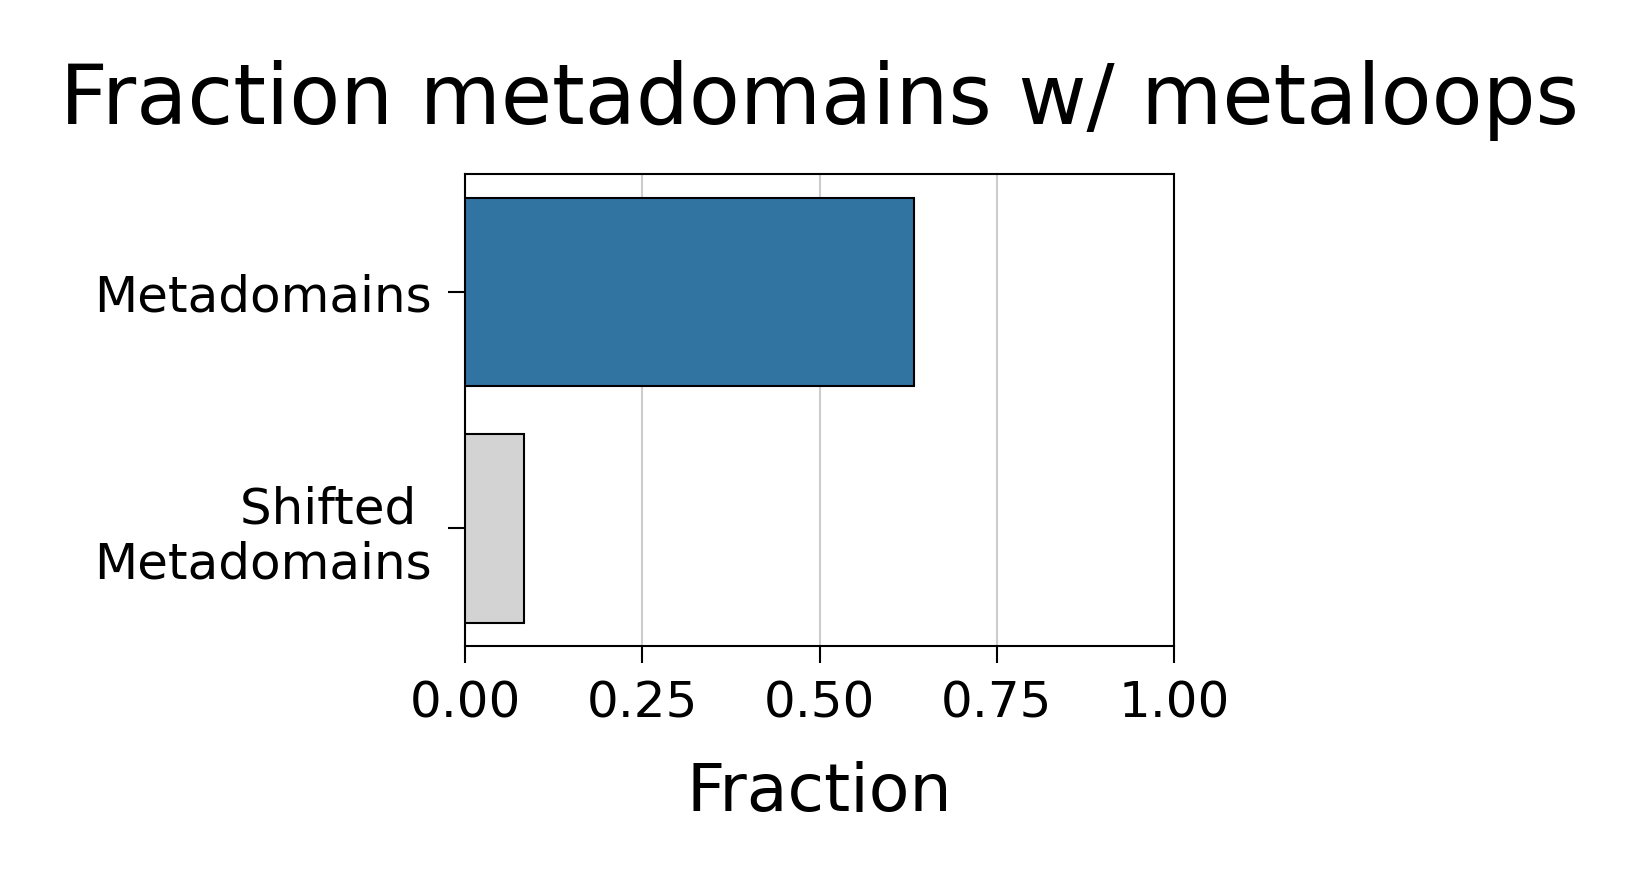

In [34]:
fig, ax = init_subplots_exact(1, 1, fgsz=(30*mm, 20*mm), dpi=300)

real_foci = pd.concat(foci_df_dict.values())
fake_foci = pd.concat(control_foci_df_dict.values())

real_foci['type'] = "Metadomains"
fake_foci['type'] = "Shifted \nMetadomains"
data = pd.concat([real_foci, fake_foci], axis=0)
barplot_data = data.groupby('type')['Focal peaks'].value_counts().unstack().T
barplot_data = barplot_data/barplot_data.sum(axis=0)
frac = barplot_data.iloc[1:, :].sum(axis=0).reset_index()
sns.barplot(data=frac, y='type', x=0, ax=ax, palette=['tab:blue', 'lightgray'], linewidth=.25, edgecolor='black',
           orient='h', zorder=3)
plt.xlabel('Fraction')
plt.title("Fraction metadomains w/ metaloops")
plt.xlim([0, 1])
plt.ylabel("")
fig.savefig('./plots/paper/fig6/metadomains_with_foci_vs_control.pdf', bbox_inches='tight', dpi=300)

#### # Metaloops per metadomain

In [35]:
data = all_inputs['Focal peaks'].value_counts().reset_index()
data.columns = ['# Metaloops', 'Count']
data['# Metaloops'] = data['# Metaloops'].astype(int)

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Count')

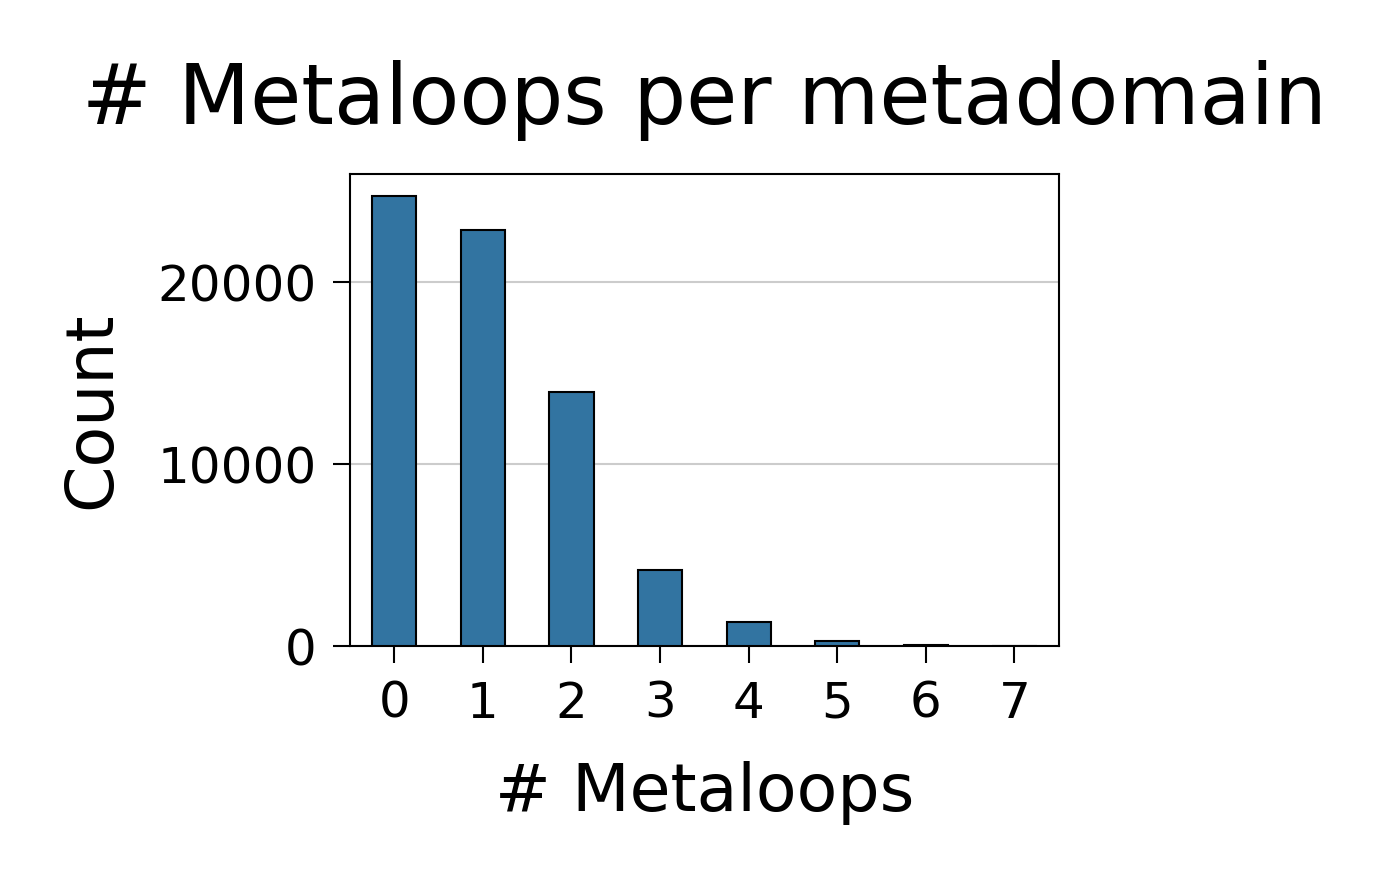

In [36]:
fig, ax = init_subplots_exact(1, 1, fgsz=(30*mm, 20*mm), dpi=300)

sns.barplot(data=data, y='Count', x='# Metaloops', ax=ax, palette=['tab:blue'], linewidth=.25, edgecolor='black', zorder=3,
           width=.5)
plt.xlabel('# Metaloops')
plt.title("# Metaloops per metadomain")
plt.ylabel("Count")

#### Accumulate all metadomains

In [37]:
def make_sorted(tup):
    x, y = sorted(tup[1:3])
    return tup[0], x, y

In [38]:
DIST_CO = 2_000_000

c = 0 
j = 0
all_metaloops = []
all_metaloops_as_loop = []
all_metaloop_anchors = []
for chrom in CHROMS_TO_USE:
    for c, metaloop in enumerate(peakfinder_result_dict[chrom]):
        input_L, input_R = input_dict[chrom].iloc[c]
        n = len(metaloop[0])
        places = list(zip([chrom]*n, metaloop[0], metaloop[1]))
        places = [p for p in places if 'Error' not in str(p[1])]
        places = map(make_int, places)
        places = list(map(make_sorted, places))
        places = [x for x in places if abs(x[2]-x[1]) >= DIST_CO]
        places = [tuple(list(x) + list(input_L) + list(input_R)) for x in places]
        all_metaloops += places

all_metaloops = pd.DataFrame(all_metaloops)
all_metaloops = all_metaloops.drop_duplicates([0, 1, 2])
all_metaloops = all_metaloops.values

for place in all_metaloops:
    chrom = place[0]
    s, e = place[1:3]
    anc1 = (chrom, s, s+5_000)
    anc2 = (chrom, e, e+5_000)
    all_metaloop_anchors.append(anc1)
    all_metaloop_anchors.append(anc2)
    all_metaloops_as_loop.append(list(anc1) + list(anc2))

In [39]:
all_metaloops = pbt.BedTool(list(all_metaloops)).saveas("final_loops/metaloops/refined_metaloops/refined_metaloops.bed")
all_metaloop_anchors = pbt.BedTool(all_metaloop_anchors).saveas("final_loops/metaloops/refined_metaloops/refined_metaloop_anchors.bed")

### Figure S19

/tmp/ipykernel_208688/3623680380.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pval_by_count_df['Focal peaks'] = pval_by_count_df['Focal peaks'].clip(0, 5)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cate

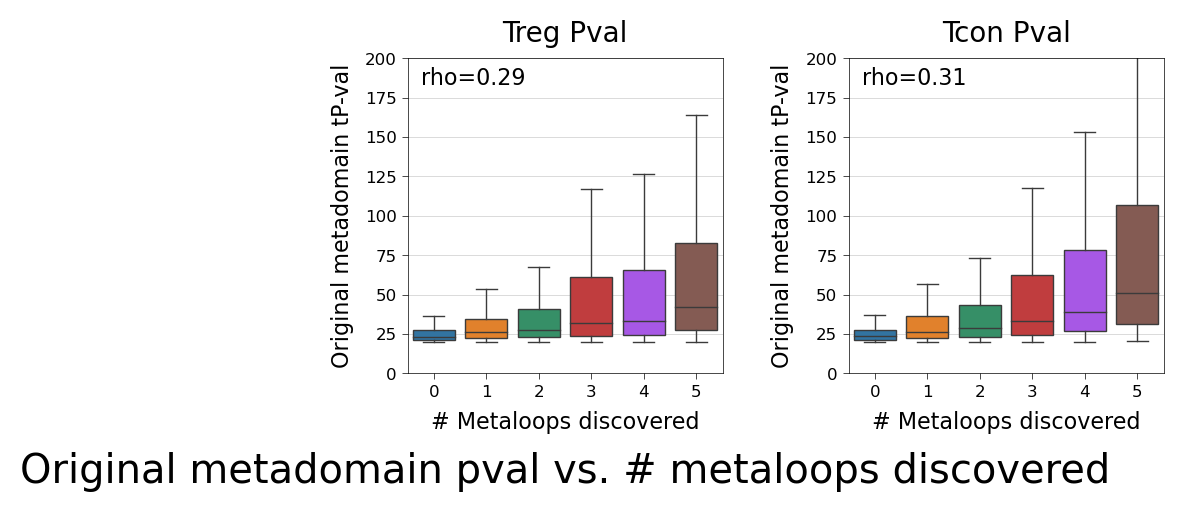

In [41]:
def remove_decimal(x, pos):
    return f"{int(x):g}"  # Convert to integer and format without decimal if possible

full_foci_df = pd.DataFrame()
for chrom in CHROMS_TO_USE:
    n_foci_df = foci_df_dict[chrom].copy()
    full_foci_df = pd.concat([full_foci_df, n_foci_df], axis=0)
    
    
fig, axs = init_subplots_exact(2, 1, fgsz=(40*mm, 40*mm), dpi = 100, xspace=1.4)
for c, key in enumerate(['Treg Pval', 'Tcon Pval']):
    plt.sca(axs[c])
    pval_by_count_df = full_foci_df[full_foci_df[key] > 0]
    pval_by_count_df['Focal peaks'] = pval_by_count_df['Focal peaks'].clip(0, 5)
    sns.boxplot(data=pval_by_count_df, x='Focal peaks', y=key, showfliers=False)
#     sns.stripplot(data=pval_by_count_df, x='Focal peaks', y=key, s=4, color='black')

    plt.tight_layout()
    spearmanr = scipy.stats.spearmanr(pval_by_count_df['Focal peaks'], pval_by_count_df[key])[0].round(2)
    plt.text(-.25, 195, f'rho={spearmanr}', va='top', ha = 'left', fontsize=8)
    x_ticks = axs[c].get_xticks()
    x_labels = axs[c].get_xticklabels()
    axs[c].set_xticks(x_ticks)
    axs[c].set_xticklabels(x_labels)
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(remove_decimal))

    plt.xlabel("# Metaloops discovered")
    plt.ylabel("Original metadomain tP-val")
    plt.suptitle(f"Original metadomain pval vs. # metaloops discovered", y=.95)
    plt.title(key)
    axs[c].set_axisbelow(True)
    plt.ylim([0, 200])
fig.savefig('./plots/paper/s28/og_pval_vs_metaloops_discovered.pdf', bbox_inches='tight')